## Optimizing Deep Learning Neural Network Model

Optimize your model in order to achieve a target predictive accuracy higher than 75% by using any or all of the following:

1. Adjusting the input data to ensure that there are no variables or outliers that are causing confusion in the model, such as:
    - Dropping more or fewer columns.
    - Creating more bins for rare occurrences in columns.
    - Increasing or decreasing the number of values for each bin.
2. Adding more neurons to a hidden layer.
3. Adding more hidden layers.
4. Using different activation functions for the hidden layers.
5. Adding or reducing the number of epochs to the training regimen.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import dependencies.
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
# Import and read the charity_data.csv.
application_df = pd.read_csv("./Resources/charity_data.csv")
print(application_df.shape)
application_df.head()

(34299, 12)


,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


### Preprocess Data

In [4]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_noid_df = application_df.drop(columns=["EIN", "NAME"], axis=1)
print(application_noid_df.shape)
application_noid_df.head()

(34299, 10)


,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [5]:
# Determine the number of unique values in each column.
application_noid_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

#### Step 1 of model optimization: dropping noisy variables

In [6]:
# Check the count of organizations with special considerations in their applications.
application_noid_df["SPECIAL_CONSIDERATIONS"].value_counts()

N    34272
Y       27
Name: SPECIAL_CONSIDERATIONS, dtype: int64

Dropped the special considerations column since it only had 2 unique values and the the organizations with special considerations were only 27 out of 34,299 applications.  

In [7]:
# Drop special considerations for application in column 'SPECIAL_CONSIDERATIONS'
charity1_df = application_noid_df.drop(columns=["SPECIAL_CONSIDERATIONS"], axis=1)
print(charity1_df.shape)
charity1_df.head()

(34299, 9)


,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,142590,1


In [8]:
# Check the count of organizations with active applications in the dataset.
charity1_df["STATUS"].value_counts()

1    34294
0        5
Name: STATUS, dtype: int64

Considering that there are only 5 applications with status (0), we opted to drop the status column from input features.

In [9]:
# Drop status of application in column 'STATUS'
charity_df = charity1_df.drop(columns=["STATUS"], axis=1)
print(charity_df.shape)
charity_df.head()

(34299, 8)


,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,0,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1-9999,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,0,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,10000-24999,6692,1
4,T3,Independent,C1000,Heathcare,Trust,100000-499999,142590,1


In [10]:
# Check the number of unique values in each column.
charity_df.nunique()

APPLICATION_TYPE      17
AFFILIATION            6
CLASSIFICATION        71
USE_CASE               5
ORGANIZATION           4
INCOME_AMT             9
ASK_AMT             8747
IS_SUCCESSFUL          2
dtype: int64

In [11]:
# Look at APPLICATION_TYPE value counts for binning
application_types = charity_df["APPLICATION_TYPE"].value_counts()
application_types

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

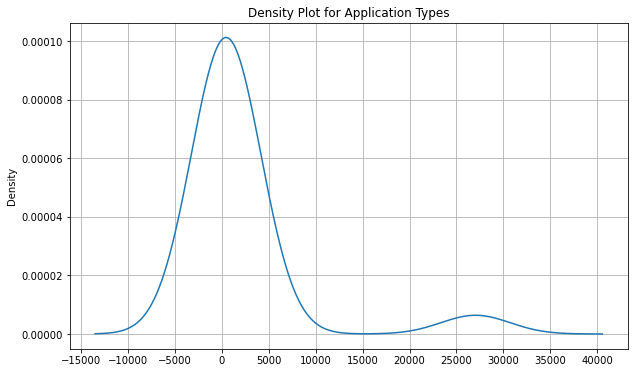

In [12]:
# Visualize the value counts of APPLICATION_TYPE
application_types.plot.density(grid=True, figsize=(10,6))
plt.xticks(range(-15000, 42000, 5000))
plt.title("Density Plot for Application Types")
plt.show()

#### Step 2 of model optimization <br>
Increased the number of values in the the 'Other' bin by increasing the cutoff for applications count.

- According to the density plot, the most common unique values for application type have more than 500 instances within the dataset.
- For the purpose of optimizing the model, we will keep only applications with the order of thousands. 
- Therefore, we can bucket any application type that appears fewer than 1000 times in the dataset as "other."

In [13]:
# Replace application type value if counts are less than 500.
replace_application = list(application_types[application_types < 1000].index)

# Replace in dataframe
for app in replace_application:
    charity_df.APPLICATION_TYPE = charity_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
charity_df.APPLICATION_TYPE.value_counts()

T3       27037
Other     2266
T4        1542
T6        1216
T5        1173
T19       1065
Name: APPLICATION_TYPE, dtype: int64

In [14]:
charity_df.APPLICATION_TYPE.unique()

array(['Other', 'T3', 'T5', 'T4', 'T6', 'T19'], dtype=object)

In [15]:
# Look at CLASSIFICATION value counts for binning
classification_values = charity_df["CLASSIFICATION"].value_counts()
classification_values.tolist()

[17326,
 6074,
 4837,
 1918,
 1883,
 777,
 287,
 194,
 116,
 114,
 104,
 95,
 75,
 58,
 50,
 36,
 34,
 32,
 32,
 30,
 20,
 18,
 16,
 15,
 15,
 14,
 11,
 10,
 10,
 9,
 9,
 7,
 6,
 6,
 6,
 5,
 5,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

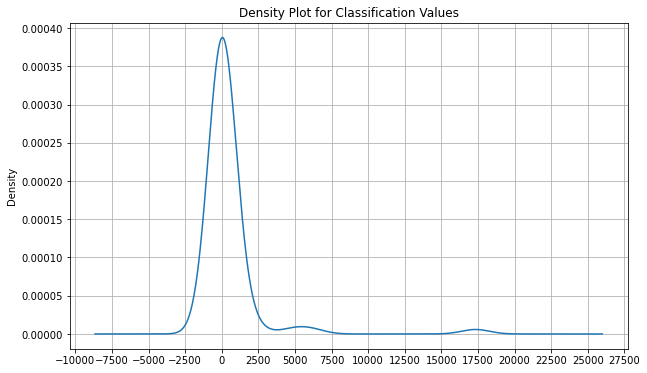

In [16]:
# Visualize the value counts of CLASSIFICATION
classification_values.plot.density(grid=True, figsize=(10,6))
plt.xticks(range(-10000, 30000, 2500))
plt.title("Density Plot for Classification Values")
plt.show()

In [17]:
# Determine which values to replace if counts are less than ..?
replace_class = list(classification_values[classification_values < 1800].index)

# Replace in dataframe
for cls in replace_class:
    charity_df.CLASSIFICATION = charity_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
charity_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [18]:
# Generate our categorical variable lists
charity_cat = charity_df.dtypes[charity_df.dtypes == "object"].index.tolist()
charity_cat

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT']

In [19]:
# Create a OneHotEncoder instance.
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list.
encode_df = pd.DataFrame(enc.fit_transform(charity_df[charity_cat]))

# Add the encoded variable names to the DataFrame.
encode_df.columns = enc.get_feature_names(charity_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Merge one-hot encoded features and drop the originals
charity_new_df = charity_df.merge(encode_df, left_index=True, right_index=True)
charity_new_df = charity_new_df.drop(charity_cat, 1)
print(charity_new_df.shape)
charity_new_df.head()

(34299, 38)


,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,5000,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,108590,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5000,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6692,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,142590,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Split our preprocessed data into our features and target arrays
y = charity_new_df.IS_SUCCESSFUL
X = charity_new_df.drop(columns=["IS_SUCCESSFUL"])

In [22]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [23]:
# Check the shapes of training/ testing datasets.
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (25724, 37)
X_test shape: (8575, 37)
y_train shape: (25724,)
y_test shape: (8575,)


In [24]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [25]:
X_train_scaled.shape

(25724, 37)

In [26]:
X_test_scaled.shape

(8575, 37)

### Deliverable 2: Compile, Train and Evaluate the Model

#### Step 3 of model optimization <br>
1. Increased the number of neurons in the first hidden layer from 80 to 100.
2. Increased the number of neurons in the second hidden layer from 30 to 80.
3. Added a third hidden layer with 60 neurons.
4. Added a fourth hidden layer with 40 neurons.
5. Changed the activation function of hidden layer from relu to tanh.

In [28]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 100
hidden_nodes_layer2 = 80
hidden_nodes_layer3 = 40
hidden_nodes_layer4 = 20

nn_optimized = tf.keras.models.Sequential()

# Add first hidden layer
nn_optimized.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, 
                            input_dim=number_input_features, 
                            activation="tanh"))
# Add second hidden layer
nn_optimized.add(tf.keras.layers.Dense(units=hidden_nodes_layer2,
                            activation="tanh"))
# Add third hidden layer
nn_optimized.add(tf.keras.layers.Dense(units=hidden_nodes_layer3,
                            activation="tanh"))
# Add fourth hidden layer
nn_optimized.add(tf.keras.layers.Dense(units=hidden_nodes_layer4,
                            activation="tanh"))
# Add output layer
nn_optimized.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

nn_optimized.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               3800      
_________________________________________________________________
dense_2 (Dense)              (None, 80)                8080      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 15,961
Trainable params: 15,961
Non-trainable params: 0
_________________________________________________________________


#### Creating Checkpoints

In [29]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

In [30]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints_optimized/", exist_ok=True)
checkpoint_path = "checkpoints_optimized/weights.{epoch:02d}.hdf5"

#### Compile and Train the Model

In [31]:
# Compile the model
nn_optimized.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [32]:
# Create a callback that saves the model's weights every 5 epochs
batch_size=32
# batches_count = (len(X_train_scaled) + len(y_train))// batch_size
batches_count = len(X_train_scaled) // batch_size
cp_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    verbose=1,
    save_weights_only=True, 
    save_freq=5*batches_count)

Number of batches = training sample size / batch size <br>
Number of iterations is equal to number of batches to finish one epoch. <br>
save_feq = either 'epoch' for every epoch, or integer which is number of batches (not epochs) to finish one epoch => if we want to save every 5 epochs, we multiply 5 by the number of batches it takes to finish one epoch.

In [33]:
# Train the model
fit_model = nn_optimized.fit(X_train_scaled, y_train, epochs=250, callbacks=[cp_callback])

Epoch 1/250
804/804 [==============================] - 1s 1ms/step - loss: 0.5689 - accuracy: 0.7241
Epoch 2/250
804/804 [==============================] - 1s 938us/step - loss: 0.5574 - accuracy: 0.7298
Epoch 3/250
804/804 [==============================] - 1s 971us/step - loss: 0.5544 - accuracy: 0.7310
Epoch 4/250
804/804 [==============================] - 1s 987us/step - loss: 0.5522 - accuracy: 0.7327
Epoch 5/250
760/804 [===========================>..] - ETA: 0s - loss: 0.5499 - accuracy: 0.7338
Epoch 00005: saving model to checkpoints_optimized\weights.05.hdf5
804/804 [==============================] - 1s 961us/step - loss: 0.5510 - accuracy: 0.7334
Epoch 6/250
804/804 [==============================] - 1s 883us/step - loss: 0.5498 - accuracy: 0.7333
Epoch 7/250
804/804 [==============================] - 1s 937us/step - loss: 0.5493 - accuracy: 0.7336
Epoch 8/250
804/804 [==============================] - 1s 867us/step - loss: 0.5482 - accuracy: 0.7357
Epoch 9/250
804/804 [=====

804/804 [==============================] - 1s 883us/step - loss: 0.5364 - accuracy: 0.7399
Epoch 63/250
804/804 [==============================] - 1s 872us/step - loss: 0.5359 - accuracy: 0.7411
Epoch 64/250
804/804 [==============================] - 1s 862us/step - loss: 0.5363 - accuracy: 0.7404
Epoch 65/250
690/804 [========================>.....] - ETA: 0s - loss: 0.5377 - accuracy: 0.7387
Epoch 00065: saving model to checkpoints_optimized\weights.65.hdf5
804/804 [==============================] - 1s 915us/step - loss: 0.5362 - accuracy: 0.7405
Epoch 66/250
804/804 [==============================] - 1s 899us/step - loss: 0.5362 - accuracy: 0.7401
Epoch 67/250
804/804 [==============================] - 1s 870us/step - loss: 0.5362 - accuracy: 0.7409
Epoch 68/250
804/804 [==============================] - 1s 861us/step - loss: 0.5362 - accuracy: 0.7408
Epoch 69/250
804/804 [==============================] - 1s 852us/step - loss: 0.5356 - accuracy: 0.7413
Epoch 70/250
709/804 [=======

804/804 [==============================] - 1s 928us/step - loss: 0.5340 - accuracy: 0.7420
Epoch 124/250
804/804 [==============================] - 1s 901us/step - loss: 0.5343 - accuracy: 0.7418
Epoch 125/250
664/804 [=======================>......] - ETA: 0s - loss: 0.5348 - accuracy: 0.7408
Epoch 00125: saving model to checkpoints_optimized\weights.125.hdf5
804/804 [==============================] - 1s 955us/step - loss: 0.5343 - accuracy: 0.7412
Epoch 126/250
804/804 [==============================] - 1s 1ms/step - loss: 0.5344 - accuracy: 0.7416
Epoch 127/250
804/804 [==============================] - 1s 1ms/step - loss: 0.5343 - accuracy: 0.7413
Epoch 128/250
804/804 [==============================] - 1s 907us/step - loss: 0.5341 - accuracy: 0.7415
Epoch 129/250
804/804 [==============================] - 1s 910us/step - loss: 0.5342 - accuracy: 0.7409
Epoch 130/250
628/804 [======================>.......] - ETA: 0s - loss: 0.5344 - accuracy: 0.7413
Epoch 00130: saving model to ch

804/804 [==============================] - 1s 904us/step - loss: 0.5343 - accuracy: 0.7418
Epoch 184/250
804/804 [==============================] - 1s 906us/step - loss: 0.5340 - accuracy: 0.7416
Epoch 185/250
569/804 [====================>.........] - ETA: 0s - loss: 0.5352 - accuracy: 0.7410
Epoch 00185: saving model to checkpoints_optimized\weights.185.hdf5
804/804 [==============================] - 1s 919us/step - loss: 0.5337 - accuracy: 0.7419
Epoch 186/250
804/804 [==============================] - 1s 942us/step - loss: 0.5341 - accuracy: 0.7406
Epoch 187/250
804/804 [==============================] - 1s 910us/step - loss: 0.5338 - accuracy: 0.7416
Epoch 188/250
804/804 [==============================] - 1s 907us/step - loss: 0.5336 - accuracy: 0.7414
Epoch 189/250
804/804 [==============================] - 1s 1ms/step - loss: 0.5341 - accuracy: 0.7412
Epoch 190/250
609/804 [=====================>........] - ETA: 0s - loss: 0.5326 - accuracy: 0.7430
Epoch 00190: saving model to 

804/804 [==============================] - 1s 919us/step - loss: 0.5335 - accuracy: 0.7415
Epoch 244/250
804/804 [==============================] - 1s 896us/step - loss: 0.5334 - accuracy: 0.7417
Epoch 245/250
504/804 [=================>............] - ETA: 0s - loss: 0.5334 - accuracy: 0.7420
Epoch 00245: saving model to checkpoints_optimized\weights.245.hdf5
804/804 [==============================] - 1s 930us/step - loss: 0.5335 - accuracy: 0.7413
Epoch 246/250
804/804 [==============================] - 1s 904us/step - loss: 0.5338 - accuracy: 0.7415
Epoch 247/250
804/804 [==============================] - 1s 909us/step - loss: 0.5342 - accuracy: 0.7418
Epoch 248/250
804/804 [==============================] - 1s 922us/step - loss: 0.5337 - accuracy: 0.7415
Epoch 249/250
804/804 [==============================] - 1s 899us/step - loss: 0.5335 - accuracy: 0.7419
Epoch 250/250
537/804 [===================>..........] - ETA: 0s - loss: 0.5322 - accuracy: 0.7421
Epoch 00250: saving model t

In [34]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_optimized.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5692 - accuracy: 0.7248
Loss: 0.5691683888435364, Accuracy: 0.724781334400177


#### Export the Model to an HDF5 File

In [47]:
# Export our model to HDF5 file
nn_optimized.save("AlphabetSoupCharity_optimization.h5")

#### Confirm Successful Model Saving

In [48]:
# Import the model to a new object
nn_imported = tf.keras.models.load_model('AlphabetSoupCharity_optimization.h5')

In [49]:
# Check the structure of the imported model.
nn_imported.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               3800      
_________________________________________________________________
dense_2 (Dense)              (None, 80)                8080      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 15,961
Trainable params: 15,961
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Evaluate the completed model using the test data.
model_loss, model_accuracy = nn_imported.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5692 - accuracy: 0.7248
Loss: 0.5691683888435364, Accuracy: 0.724781334400177
